In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

%load_ext autoreload
%autoreload 2
from pyPALM.grouping import group
import palm_diagnostics as pdiag

In [2]:
# make random test data
palm_df = pdiag.PALMData("Run4_488nm_0_dc_IDL.sav")

E:\Box Sync\Python\Scripts\palm_diagnostics.py:53: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.totalrawdata = sav["totalrawdata"]


In [3]:
palm_df.processed.max()

x0             798.951538
y0             828.507141
nphotons    384689.000000
frame       322749.000000
sigma_x          0.249993
sigma_y          0.249999
sigma_z        249.994247
z0             652.535095
offset        1375.592651
amp          38599.218750
dtype: float64

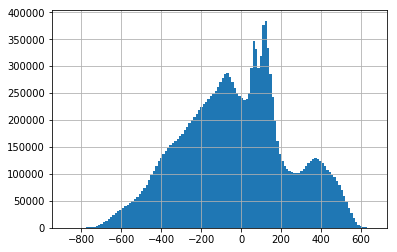

In [4]:
palm_df.processed.z0.hist(bins=128)

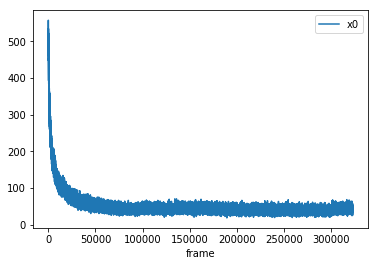

In [5]:
palm_df.raw_counts.plot()

In [ ]:
with pdiag.pb:
    cimg = pdiag.gen_img(palm_df.totalrawdata.shape,
                         palm_df.processed[(palm_df.processed.z0 > -400) & (palm_df.processed.z0 < 400)],
                         diffraction_limit=True)

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e41b2f2d30>)

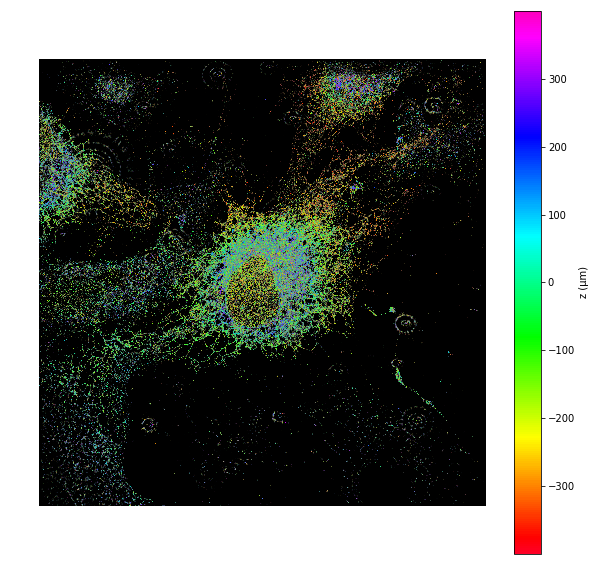

In [7]:
cimg.plot(norm_kwargs=dict(gamma=0.5, vmax=0.01), subplots_kwargs=dict(figsize=(10,10)))

In [6]:
palm_short = palm_df.processed[palm_df.processed.frame > 3e5]

In [9]:
%time palm_df_grp = group(palm_short, 0.1, 250)

KeyboardInterrupt: 

In [10]:
%time palm_df_grp = group(palm_short, 0.2, 75)
palm_df_grp.head()

KeyboardInterrupt: 

NameError: name 'palm_df_grp' is not defined

In [ ]:
palm_df_grp.head()

In [ ]:
%time palm_df_grp = group(palm_short, 0.1, 250, 250)

In [ ]:
%time palm_df_grp = group(palm_short, 0.2, 75, 250)

In [ ]:
palm_short_short = palm_df.processed[palm_df.processed.frame > palm_df.processed.frame.max() - 250]

In [ ]:
%time palm_df_grp = group(palm_short_short, 0.2, 75)
palm_df_grp.head()

In [ ]:
def agg_groups(df_grouped):
    def f(x):
        if len(x) < 2:
            x = x.drop("group_id", 1)
            x["groupsize"] = 1
            return x
        
        coords = ["x", "y", "z"]
        x0s = [c + '0' for c in coords]
        sigmas = ["sigma_" + c for c in coords]
        
        d = pd.DataFrame(np.nan, columns=x0s + sigmas, index=x.index[:1])
        inv_sigma = (1 / x[sigmas].values**2).sum(0)
        d[sigmas] = 1 / np.sqrt(inv_sigma)
        
        d[x0s] = (x[x0s].values / x[sigmas].values**2).sum(0) / inv_sigma
            
        d["nphotons"] = x["nphotons"].sum()
        d["amp"] = x["amp"].sum()
        d["offset"] = x["offset"].mean()
        d["groupsize"] = len(x)
        d["frame"] = x["frame"].iloc[0]

        return d

    a = df_grouped.groupby("group_id").apply(f)
    a.index = a.index.droplevel(1)
    return a

In [ ]:
def agg_groups2(df_grouped):
        
    coords = ["x", "y", "z"]
    # these are our weights
    w_coords = []
    weights = []
    
    for c in coords:
        s = "sigma_" + c
        df_grouped[s + "_inv"] = 1 / df_grouped[s] ** 2
        weights.append(s + "_inv")
        x = c + "0"
        df_grouped[x + "_w"] = df_grouped[x].mul(df_grouped[s + "_inv"], "index")
        w_coords.append(x + "_w")
    # groupby group_id and sum
    temp_gb = df_grouped.groupby("group_id")

    new_coords = temp_gb[w_coords].sum() / temp_gb[weights].sum().values
    new_coords.columns = [c.replace("_w", "") for c in new_coords.columns]
    
    new_sigmas = np.sqrt(1 / temp_gb[weights].sum())
    new_sigmas.columns = [c.replace("_inv", "") for c in new_sigmas.columns]
    
    new_amp = temp_gb[["amp", "nphotons"]].sum()
    new_frame = temp_gb[["frame"]].first()
    groupsize = temp_gb.x0.count()
    groupsize.name = "groupsize"
    new_offset = temp_gb[["offset"]].mean()

    df_grouped.drop(columns=w_coords + weights, inplace=True)
    return pd.concat([new_coords, new_sigmas, new_amp, new_frame, groupsize, new_offset], axis=1)

In [ ]:
%time a = agg_groups(palm_df_grp)

In [ ]:
%time b = agg_groups2(palm_df_grp)

In [ ]:
a.head()

In [ ]:
b.head()

In [ ]:
a.columns

In [ ]:
b.columns

In [ ]:
np.allclose(a, b[a.columns])

In [ ]:
groups = palm_df_grp.groupby("group_id")

In [ ]:
group_sizes = groups.x0.count()

In [ ]:
group_sizes.idxmax()

In [ ]:
a_group = palm_df_grp[palm_df_grp.group_id == group_sizes.idxmax()]

In [ ]:
a_group.plot("x0", "y0", kind="scatter")

In [ ]:
a_group[["x0", "y0", "z0"]].plot(subplots=True)

$$
\sigma_x^{gr} = \sqrt{
\frac{\sum_{i=0}^{n_{peaks}-1}(x_i - \bar{x})^2 Nphot_i}{n_{peaks} \sum_{i=0}^{n_{peaks}-1} Nphot_i} +
\frac{\sum_{i=0}^{n_{peaks}-1}\sigma_{x_i}^2 Nphot_i}{n_{peaks} \sum_{i=0}^{n_{peaks}-1} Nphot_i}
}
$$

$$
\sigma_x^{gr} = \sqrt{
\frac{\sum_{i=0}^{n_{peaks}-1}Nphot_i\left((x_i - \bar{x})^2 + \sigma_{x_i}^2\right)}{n_{peaks} \sum_{i=0}^{n_{peaks}-1} Nphot_i}
}
$$

In [ ]:
%load_ext line_profiler

In [ ]:
from pyPALM.grouping import find_matches

def group2(df, radius, gap, frame_reset=np.inf):
    """Group peaks based on x y locations

    Parameters
    ----------
    df : pandas DataFrame
    radius : float
    gap : int
    frame_reset : int"""
    new_df_list = []
    # should add a progress bar here
    frame_min = df.frame.min()
    for frame, peaks in df.groupby("frame"):
        peaks = peaks.reset_index()
        # set/reset group_id
        if not (frame - frame_min) % frame_reset:
            # group_id will be the index of the first peak
            df_cache = peaks.copy()
#             df_cache.loc[peaks.index, "index"] = df_cache.index
            new_df_list.append(peaks)
            continue
        # search for matches
        matches = find_matches([df_cache[["y0", "x0"]].values, peaks[["y0", "x0"]].values], radius)
        # get indices
        # need to deal with overlaps (two groups claim same peak)
        try:
            # if there is a new peak that matches to two or more different cached peaks then the newer of the
            # cached peaks claims it. If the cached peaks have the same age then its a toss up.
            cache_idx, peaks_idx = np.array([[df_cache.index[i], peaks.index[m]] for i, m in matches]).T
        except ValueError as error:
            # should log the error or raise as a warning.
            pass
        else:
            # update groups
            # need to use .values, because list results in DF
            peaks.loc[peaks_idx, "index"] = df_cache.loc[cache_idx, "index"].values
        # ungrouped peaks get their own group_id
#         peaks.group_id.where((peaks.group_id != -1), peaks.index, inplace=True)
        # peaks.loc[(peaks.group_id != -1), "group_id"] = peaks.index
        # update df_cache and lifetimes
        # updating the cache takes a significant amount of time.
        df_cache = pd.concat((df_cache, peaks))
        df_cache = df_cache.drop_duplicates("index", "last")
        df_cache = df_cache[(frame - df_cache.frame) < gap]
        df_cache.reset_index(drop=True, inplace=True)
        new_df_list.append(peaks)
    return pd.concat(new_df_list).rename(columns={"index":"group_id"})

In [ ]:
gg = g1.reset_index()

In [ ]:
gg.reset_index()

In [ ]:
%time g1 = group(palm_short_short, 0.2, 75)
%time g2 = group2(palm_short_short, 0.2, 75)
np.allclose(g2.values, g1[g2.columns].values)

In [ ]:
g1.head()

In [ ]:
g2.head()

In [ ]:
g2.groupby("group_id").x0.count().plot()

In [ ]:
g1.groupby("group_id").x0.count().plot()

In [ ]:
g.set_index("group_id").reset_index()

In [ ]:
%lprun -f group2 group2(palm_short_short, 0.2, 75)

In [6]:
from distributed import Client, LocalCluster

In [9]:
client = Client("10.102.20.83:8786")

In [10]:
client

Client Scheduler: tcp://10.102.20.83:8786 Dashboard: http://10.102.20.83:8787/status,Cluster Workers: 24 Cores: 48 Memory: 549.67 GB


In [13]:
%time group(palm_short, 0.2, 75)

distributed.core - WARNING - Event loop was unresponsive in Scheduler for 1.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Worker for 1.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Worker for 5.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 5.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


Wall time: 4min 34s


,x0,y0,nphotons,frame,sigma_x,sigma_y,sigma_z,z0,offset,amp,group_id
15357875,732.754883,527.930237,30109.0,300001,0.007091,0.010671,6.568109,-344.289093,97.614517,2903.402100,15357875
15357876,492.138672,701.626831,14024.0,300001,0.014006,0.011564,10.499922,188.134644,56.157936,1398.752197,15357876
15357877,431.196625,567.600830,8379.0,300001,0.016795,0.015147,12.603529,86.183990,46.728855,879.947266,15357877
15357878,268.625580,474.765076,7516.0,300001,0.018069,0.016047,13.364905,94.629807,45.496101,786.555969,15357878
15357879,232.786346,817.438599,6014.0,300001,0.035752,0.025389,35.657726,468.668976,148.813980,492.844635,15357879
15357880,544.343506,36.721539,1550.0,300001,0.041513,0.065075,41.382118,-356.974060,40.743076,147.968857,15357880
15357881,596.584900,169.359818,5054.0,300001,0.025261,0.020422,19.750162,182.545425,44.818043,505.570618,15357881
15357882,396.223206,358.615784,1527.0,300001,0.040021,0.056224,36.614925,-225.636368,35.536415,158.626328,15357882
15357883,213.276230,688.534973,3161.0,300001,0.028912,0.026417,21.302309,74.140785,29.654600,333.538300,15357883
15357884,339.035522,386.618622,1306.0,300001,0.049205,0.064347,42.429913,-212.953003,41.539673,136.433792,15357884


In [24]:
palm_df.processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16332517 entries, 0 to 16332516
Data columns (total 10 columns):
x0          float64
y0          float64
nphotons    float64
frame       int32
sigma_x     float64
sigma_y     float64
sigma_z     float64
z0          float64
offset      float64
amp         float64
dtypes: float64(9), int32(1)
memory usage: 1.2 GB


In [18]:
%%time
scattered_data = []
bins = pd.cut(palm_df.processed.frame, 48, retbins=True)[1]
for i in range(len(bins) - 1):
    scattered_data.append(client.scatter(palm_df.processed[(palm_df.processed.frame > bins[i]) & (palm_df.processed.frame <= bins[i+1])])
    )

Wall time: 38 s


In [19]:
len(scattered_data)

48

In [20]:
%%time
result_data = [client.submit(group, sd, 0.2, 0.75) for sd in scattered_data]
result_data

Wall time: 49.5 ms


In [21]:
%time to_compute = client.gather(result_data)

Wall time: 3min 51s


In [22]:
to_compute

[                 x0          y0  nphotons  frame   sigma_x   sigma_y  \
 0        732.693176  527.917175  351964.0      0  0.002030  0.002837   
 1        492.143036  701.491699  145137.0      0  0.004078  0.003471   
 2        431.181946  567.586060   98777.0      0  0.004563  0.004149   
 3        268.640533  474.780701   93042.0      0  0.004965  0.004195   
 4        213.344879  688.451660   34072.0      0  0.008408  0.007070   
 5        441.029816  650.650146   52605.0      0  0.008932  0.006129   
 6        596.694519  169.486710   74951.0      0  0.005651  0.004806   
 7        593.764648  531.241089   32301.0      0  0.007504  0.007976   
 8        129.482559  653.341370   21678.0      0  0.010680  0.009774   
 9        253.939896  718.639221   17971.0      0  0.015928  0.010738   
 10       203.542236  360.675873    7579.0      0  0.031025  0.030959   
 11       625.332886  317.587769    4018.0      0  0.025654  0.046247   
 12       447.680420  450.972748    3625.0      0  

In [15]:
%time to_compute = dask.delayed(to_compute).compute()

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\distributed\worker.py:741: UserWarning: Large object of size 1.48 MB detected in task graph: 
  (                  x0          y0  nphotons   fram ... umns], 0.2, 75)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))
distributed.core - WARNING - Event loop was unresponsive in Worker for 1.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 7.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING

Wall time: 5min 24s


In [16]:
split = pd.concat(to_compute)

In [17]:
split

,x0,y0,nphotons,frame,sigma_x,sigma_y,sigma_z,z0,offset,amp,group_id
15357875,732.754883,527.930237,30109.0,300001,0.007091,0.010671,6.568109,-344.289093,97.614517,2903.402100,15357875
15357876,492.138672,701.626831,14024.0,300001,0.014006,0.011564,10.499922,188.134644,56.157936,1398.752197,15357876
15357877,431.196625,567.600830,8379.0,300001,0.016795,0.015147,12.603529,86.183990,46.728855,879.947266,15357877
15357878,268.625580,474.765076,7516.0,300001,0.018069,0.016047,13.364905,94.629807,45.496101,786.555969,15357878
15357879,232.786346,817.438599,6014.0,300001,0.035752,0.025389,35.657726,468.668976,148.813980,492.844635,15357879
15357880,544.343506,36.721539,1550.0,300001,0.041513,0.065075,41.382118,-356.974060,40.743076,147.968857,15357880
15357881,596.584900,169.359818,5054.0,300001,0.025261,0.020422,19.750162,182.545425,44.818043,505.570618,15357881
15357882,396.223206,358.615784,1527.0,300001,0.040021,0.056224,36.614925,-225.636368,35.536415,158.626328,15357882
15357883,213.276230,688.534973,3161.0,300001,0.028912,0.026417,21.302309,74.140785,29.654600,333.538300,15357883
15357884,339.035522,386.618622,1306.0,300001,0.049205,0.064347,42.429913,-212.953003,41.539673,136.433792,15357884
